<a href="https://colab.research.google.com/github/Guillaume-mcgill/school/blob/main/COMP551_Assignment3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Samuel Bernard [260983658]                                                                             
Mohul Sharma [260986320]                                                                  
Guillaume Rodier [260975661]

***IMPORTS***



In [ ]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf


from typing import List
from tqdm import tqdm

np.random.seed(1234)

***TASK 1: Acquire the Fashion-MNIST data***

Loading the data

In [ ]:
#calling the data
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()

Exploratory analysis

In [ ]:
#Count number of times each label appear in training
def counter(inputData,labelList):
  counters={}
  for label in labelList:
    counters[label]=np.count_nonzero(inputData==label)
  print(counters)
  return counters

train_count_d=counter(train_labels,list(range(10)))
test_count_d=counter(test_labels,list(range(10)))

{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


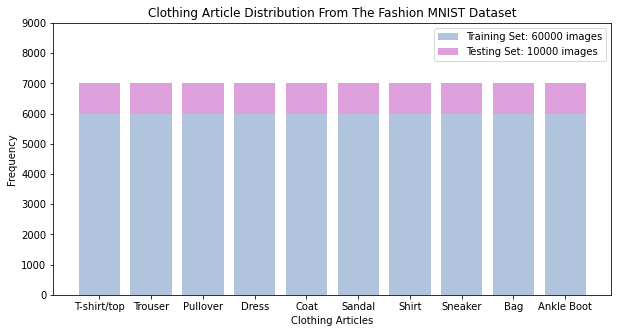

In [ ]:
# Making the clothing article distribution
label_combined=np.concatenate((train_labels,test_labels))
labels=['T-shirt/top','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot']
cneg=['tomato']
cpos=['yellowgreen']

train_count_l=[]
test_count_l=[]
for key,value in train_count_d.items():
  train_count_l.append(value)
for key,value in test_count_d.items():
  test_count_l.append(value)

plt.figure(figsize=(10,5))
c=['lightsteelblue','plum']
lab=np.arange(len(labels))
plt.bar(lab,train_count_l,align='center',color=c[0])
plt.bar(lab,test_count_l,align='center',color=c[1],bottom=train_count_l)
plt.legend(['Training Set: '+str(train_labels.shape[0])+' images', 'Testing Set: '+str(test_labels.shape[0])+' images'])
plt.xticks(lab,labels)
plt.ylim((0, 9000))
#plt.legend(['Positive Reviews: '+str(valuepos),'Negative Reviews: '+str(valueneg)])
plt.xlabel('Clothing Articles')
plt.ylabel('Frequency')
plt.title('Clothing Article Distribution From The Fashion MNIST Dataset')
plt.show()


Preprocessing the data

In [ ]:
#Our images are in greyscale with values in 255 but a neural network works better with normalize data
test_images1=test_images/255.0
train_images1=train_images/255.0

#Next, we need to flatten the input
def flatten(input_image):
  train_image_empt=np.zeros((input_image.shape[0],(input_image.shape[1]**2)))
  for image in range(input_image.shape[0]):
    train_image_empt[image,:]=input_image[image,:].flatten()
  #print(train_image_empt.shape)
  return train_image_empt


train_I=flatten(train_images1)
test_I=flatten(test_images1)


***TASK 2: Implement an MLP to classify image data***

Core MLP architecture:

In [ ]:
class NeuralNetLayer:
    def __init__(self):
        self.gradient = None
        self.parameters = None

    def forward(self, x):
        raise NotImplementedError

    def backward(self, gradient):
        raise NotImplementedError

We will only look at linear layers (or fully connected layers):

In [ ]:
class LinearLayer(NeuralNetLayer):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.ni = input_size
        self.no = output_size
        self.w = np.random.randn(output_size, input_size)
        self.b = np.random.randn(output_size)
        self.cur_input = None
        self.parameters = [self.w, self.b]

    def forward(self, x):
        self.cur_input = x
        #print(x.shape)
        return (self.w[None, :, :] @ x[:, :, None]).squeeze() + self.b

    def backward(self, gradient):
        assert self.cur_input is not None, "Must call forward before backward"
        #dw = gradient.dot(self.cur_input)
        dw = gradient[:, :, None] @ self.cur_input[:, None, :]
        db = gradient
        self.gradient = [dw, db]
        return gradient.dot(self.w)

ReLU activation function:

In [ ]:
class ReLULayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        self.gradient = np.where(x > 0, 1.0, 0.0)
        return np.maximum(0, x)

    def backward(self, gradient):
        assert self.gradient is not None, "Must call forward before backward"
        return gradient * self.gradient

Softmax activation function:

In [ ]:
class SoftmaxOutputLayer(NeuralNetLayer):
    def __init__(self):
        super().__init__()
        self.cur_probs = None

    def forward(self, x):
        exps = np.exp(x-np.max(x,axis=-1,keepdims=True))
        probs = exps / np.sum(exps, axis=-1)[:, None]
        self.cur_probs = probs
        return probs

    def backward(self, target):
        assert self.cur_probs is not None, "Must call forward before backward"
        return self.cur_probs - target

TanH activation function:

In [ ]:
class TanHLayer(NeuralNetLayer):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    exp_p = np.exp(x)
    exp_n = np.exp(-x)
    tanh =(exp_p - exp_n)/(exp_p + exp_n)
    self.gradient = 1-tanh**2
    return tanh

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient*self.gradient

Leaky ReLU activation function:

In [ ]:
class LeakyReLU(NeuralNetLayer):
  def __init__(self, alpha):
    super().__init__()
    self.alpha = alpha

  def forward(self, x):
    self.gradient = np.where(x>0,1.0,0.0) + self.alpha*np.where(x<0,1,0)
    return np.maximum(x,0) + self.alpha*np.minimum(x,0)

  def backward(self, gradient):
    assert self.gradient is not None, "Must call forward before backward"
    return gradient*self.gradient

Tie the architecture together with the MLP class:

(Remember, the backpropagation algorithm serves the purpose of computing high-dimensional gradients via the chain rule. It is not in charge of updating the parameters -- this will be the job of the optimization algorithm which we will implement shortly)

In [ ]:
class MLP:
    def __init__(self, *args: List[NeuralNetLayer]):
        self.layers = args

    def forward(self, x):
        for layer in self.layers:
            x = layer.forward(x)
        return x

    def backward(self, target):
        for layer in self.layers[::-1]:
            target = layer.backward(target)


    def gradient_check(self, x,y):
      for layer in self.layers:
          if isinstance(layer, LinearLayer):

            diff = np.zeros((layer.no,layer.ni))
            w = layer.w.copy()

            for i in range(layer.no):
              for j in range(layer.ni):

                epsilon = np.zeros((layer.no,layer.ni))
                epsilon[i, j] = np.random.rand()*1e-4

                layer.w = layer.w + epsilon
                yh1 = self.forward(x)
                J1 = -(y * np.log(yh1)).sum(axis=-1).mean()
                layer.w = w

                layer.w = layer.w - epsilon
                yh2 = self.forward(x)
                J2 = -(y * np.log(yh2)).sum(axis=-1).mean()
                layer.w = w

                numeric_grad = (J1 - J2) / (2 * epsilon[i, j])
                derived_grad = (layer.gradient[0].mean(axis=0))[i, j]
                print("numeric gradient", numeric_grad)
                print("analytic gradient", derived_grad)
                diff[i, j] = np.square(derived_grad - numeric_grad) / np.square(derived_grad + numeric_grad)
            print("Gradient comparation: ", diff)


    def train(self, optimizer, data_x, data_y, steps, bs):
      losses = []
      labels = np.eye(10)[np.array(data_y)]
      n=0  #simply to get a random array of indices so that we can have a non-bias sample of testing and training data
      sample=data_x.shape[0]
      for _ in tqdm(range(steps)):
        permut=np.random.permutation(sample)
        batches=sample/bs
        i=0
        for batch in range(1,int(batches)+1):
          i+=1

          x = data_x[permut[(batch-1)*bs:(batch*bs)],:]
          y = labels[permut[(batch-1)*bs:(batch*bs)],:]
          predictions = self.forward(x)


          self.backward(y)
          optimizer.step()
          loss = -(y * np.log(predictions)).sum(axis=-1).mean()

          losses.append(loss)

      l = list(np.arange(len(losses)))
      ticks = []
      ticks_labels = []
      for num in l:
        if (num/batches).is_integer():
          ticks.append(num)
          ticks_labels.append(int(num/batches+1))
      leaps = np.rint(len(ticks_labels)/10)
      b = 0
      graph_ticks = []
      graph_ticks_labels = []
      while b < len(ticks_labels):
        graph_ticks.append(ticks[b])
        graph_ticks_labels.append(ticks_labels[b])
        b = b + leaps
        if leaps==0:
          break
      fig = plt.figure()
      ax = fig.add_axes([0, 0, 1, 1])
      ax.plot(losses)
      ax.set_xticks(graph_ticks)
      ax.set_xticklabels(graph_ticks_labels)
      plt.xlabel('Epoch')
      plt.ylabel('Cross Entropy Loss')
      plt.show()



    def predict(self,input_da):
      liste=[]
      input_d=self.forward(input_da)
      for row in input_d:
        liste.append(np.argmax(row))

      return np.array(liste)

The Abstract optimizer interface has the following functions:


*   update: takes a set of parameters and a set of gradients, and uses the gradients to modify the parameters
*   step: traverses over the layers of an MLP and applies update to each layer

To make a new optimization algorithm, just make a subclass of Optimizer and implement the update method

In [ ]:
class Optimizer:
    def __init__(self, net: MLP):
        self.net = net

    def step(self):
        for layer in self.net.layers[::-1]:
            if layer.parameters is not None:
                self.update(layer.parameters, layer.gradient)

    def update(self, params, gradient):
        raise NotImplementedError


class GradientDescentOptimizer(Optimizer):
    def __init__(self, net: MLP, lr: float):
        super().__init__(net)
        self.lr = lr

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0)


class GradientDescent_L2Regularized(Optimizer):                       # New class for L2 regularization
    def __init__(self, net: MLP, lr: float, lambda_L2):
        super().__init__(net)
        self.lr = lr
        self.lambda_L2 = lambda_L2

    def update(self, params, gradient):
        for (p, g) in zip(params, gradient):
            p -= self.lr * g.mean(axis=0) + self.lambda_L2*p[0]

***TASK 3: Run The Experiments***

Finding the optimal learning rate using a 2-layer MLP

In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 20
n_features=train_I.shape[1]
BATCH_SIZE = 32

100%|██████████| 20/20 [18:58<00:00, 56.92s/it]


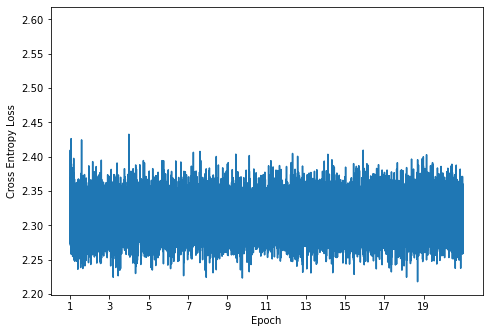

10.0


In [ ]:
LEARN_RATES = [1, 1e-1, 1e-2, 1e-3]

mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, LEARN_RATES[0])

mlp2.train(opt2, train_I, train_labels, GRADIENT_STEPS, BATCH_SIZE)

yh=mlp2.predict(test_I)
accLR1=(sum(yh==np.array(test_labels)))/yh.shape[0] * 100
print(accLR1)

100%|██████████| 20/20 [18:54<00:00, 56.70s/it]


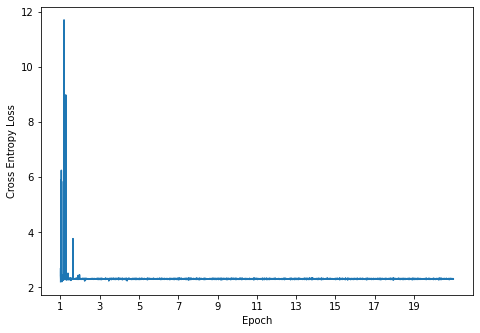

10.0


In [ ]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, LEARN_RATES[1])

mlp2.train(opt2, train_I, train_labels, GRADIENT_STEPS, BATCH_SIZE)

yh=mlp2.predict(test_I)
accLR2=(sum(yh==np.array(test_labels)))/yh.shape[0] * 100
print(accLR2)

100%|██████████| 20/20 [18:44<00:00, 56.23s/it]


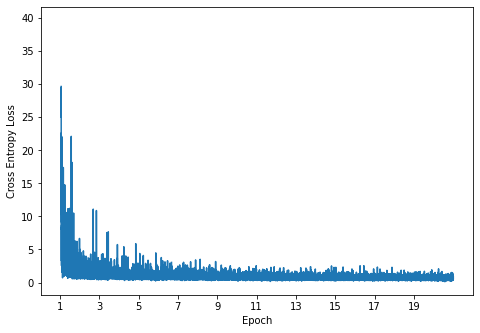

74.58


In [ ]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, LEARN_RATES[2])

mlp2.train(opt2, train_I, train_labels, GRADIENT_STEPS, BATCH_SIZE)

yh=mlp2.predict(test_I)
accLR3=(sum(yh==np.array(test_labels)))/yh.shape[0] * 100
print(accLR3)

100%|██████████| 20/20 [18:43<00:00, 56.19s/it]


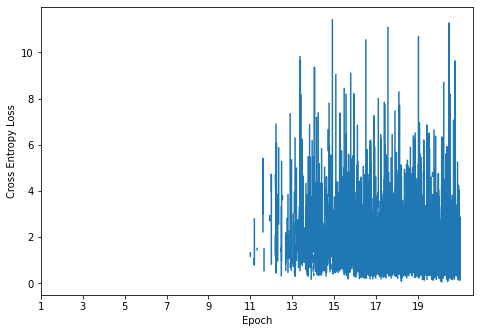

77.14999999999999


In [ ]:
mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, LEARN_RATES[3])

mlp2.train(opt2, train_I, train_labels, GRADIENT_STEPS, BATCH_SIZE)

yh=mlp2.predict(test_I)
accLR4=(sum(yh==np.array(test_labels)))/yh.shape[0] * 100
print(accLR4)

Comparing MLPs with different number of layers: Normalized Input Data

In [ ]:
LEARN_RATE = 1e-2

100%|██████████| 20/20 [00:51<00:00,  2.55s/it]


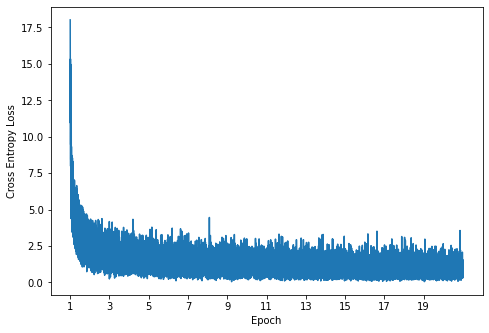

76.81


In [ ]:
#0-layer MLP
mlp0 = MLP(
    LinearLayer(n_features, 10),
    SoftmaxOutputLayer()
)

opt0 = GradientDescentOptimizer(mlp0, LEARN_RATE)

mlp0.train(opt0, train_I, train_labels, GRADIENT_STEPS, BATCH_SIZE)
yh = mlp0.predict(test_I)
acc0=(sum(yh==np.array(test_labels)))/yh.shape[0] * 100
print(acc0)

100%|██████████| 20/20 [16:33<00:00, 49.67s/it]


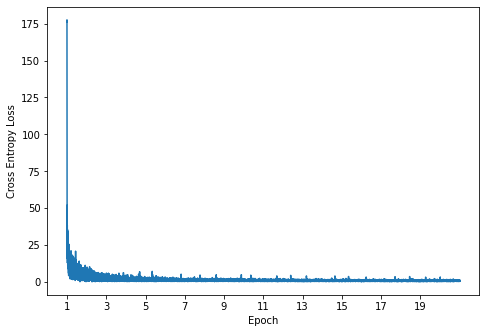

78.77


In [ ]:
#1-layer MLP
mlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, LEARN_RATE)

mlp1.train(opt1, train_I, train_labels, GRADIENT_STEPS, BATCH_SIZE)
yh=mlp1.predict(test_I)
acc1=(sum(yh==np.array(test_labels)))/yh.shape[0] * 100
print(acc1)

#2-layer MLP with chosen learning rate is shown in the learning-rate selection protcol

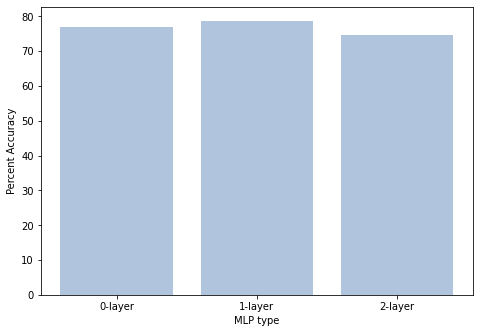

In [ ]:
#Plotting the results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
mlp_types = ['0-layer', '1-layer', '2-layer']
accuracies = [acc0, acc1, accLR3]
ax.bar(mlp_types, accuracies,align='center',color=c[0])
plt.xlabel('MLP type')
plt.ylabel('Percent Accuracy')
plt.show()

Comparing MLPs with different number of layers: Unnormalized Input Data

In [ ]:
#Calling the data
fashion_mnist=tf.keras.datasets.fashion_mnist
(train_images,train_labels),(test_images,test_labels)=fashion_mnist.load_data()
train_I1=flatten(train_images)
test_I1=flatten(test_images)

100%|██████████| 20/20 [00:51<00:00,  2.59s/it]


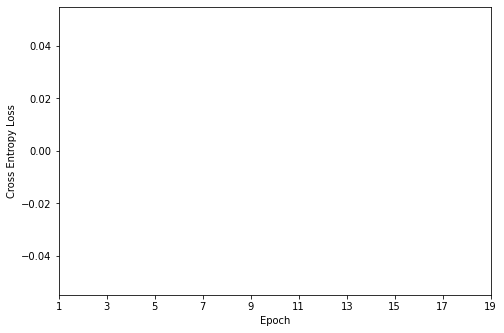

100%|██████████| 20/20 [15:05<00:00, 45.29s/it]


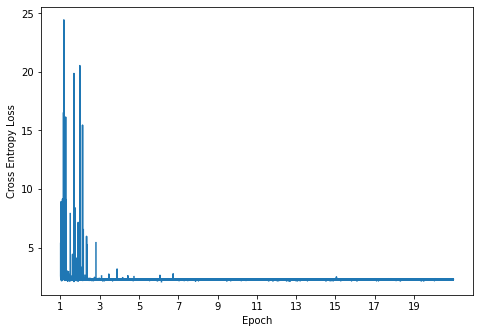

100%|██████████| 20/20 [17:43<00:00, 53.19s/it]


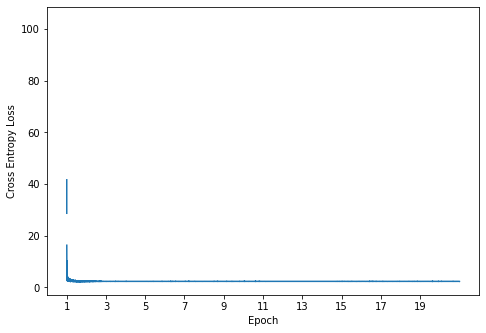

In [ ]:
mlp0 = MLP(
    LinearLayer(n_features, 10),
    SoftmaxOutputLayer()
)



mlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

mlp2 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt0 = GradientDescentOptimizer(mlp0, LEARN_RATE)
opt1 = GradientDescentOptimizer(mlp1, LEARN_RATE)
opt2 = GradientDescentOptimizer(mlp2, LEARN_RATE)

mlp0.train(opt0, train_I1, train_labels, GRADIENT_STEPS, BATCH_SIZE)
mlp1.train(opt1, train_I1, train_labels, GRADIENT_STEPS, BATCH_SIZE)
mlp2.train(opt2, train_I1, train_labels, GRADIENT_STEPS, BATCH_SIZE)

yh0=mlp0.predict(test_I1)
yh1=mlp1.predict(test_I1)
yh2=mlp2.predict(test_I1)

acc0=(sum(yh0==np.array(test_labels)))/yh0.shape[0] * 100
acc1=(sum(yh1==np.array(test_labels)))/yh1.shape[0] * 100
acc2=(sum(yh2==np.array(test_labels)))/yh2.shape[0] * 100

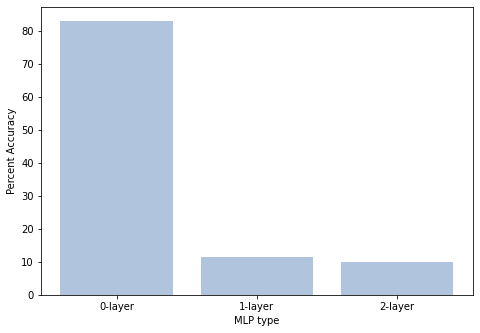

In [ ]:
#Plotting the results
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
mlp_types = ['0-layer', '1-layer', '2-layer']
accuracies = [acc0, acc1, acc2]
ax.bar(mlp_types, accuracies,align='center',color=c[0])
plt.xlabel('MLP type')
plt.ylabel('Percent Accuracy')
plt.show()

Comparing a 2-layer MLP to a ConvNet

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64,(3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 1600)              0         
                                                                 
 dense (Dense)               (None, 128)               2

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.save_weights('model.h5')

In [ ]:
history=model.fit(train_images1,train_labels, epochs=5)

Epoch 1/5
1875/1875 [==============================] - 110s 58ms/step - loss: 0.4633 - accuracy: 0.8293
Epoch 2/5
1875/1875 [==============================] - 105s 56ms/step - loss: 0.3040 - accuracy: 0.8885
Epoch 3/5
1875/1875 [==============================] - 104s 56ms/step - loss: 0.2544 - accuracy: 0.9053
Epoch 4/5
1875/1875 [==============================] - 106s 56ms/step - loss: 0.2205 - accuracy: 0.9176
Epoch 5/5
1875/1875 [==============================] - 104s 55ms/step - loss: 0.1964 - accuracy: 0.9260


In [ ]:
test_loss=model.evaluate(test_images1,test_labels)

313/313 [==============================] - 6s 20ms/step - loss: 0.2455 - accuracy: 0.9139


Displaying and Plotting Training Accuracy

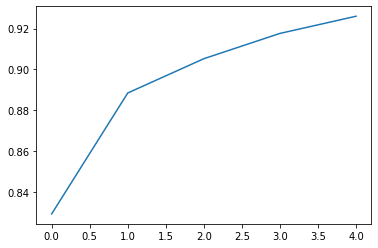

In [ ]:
plt.plot(history.history['accuracy'])

Building and Training a 2 Layers MLP

(Using TanH)

100%|██████████| 20/20 [18:33<00:00, 55.70s/it]


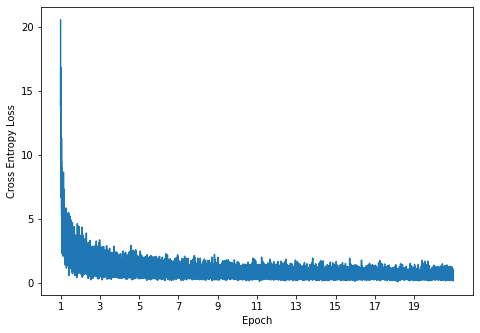

0.7617


In [ ]:
mlp3 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    TanHLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanHLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt3 = GradientDescentOptimizer(mlp3, 1e-2)

mlp3.train(opt3, train_I, train_labels, GRADIENT_STEPS,32)
yh3 = mlp3.predict(test_I)
acc = sum(yh3 == np.array(test_labels))
accuracy = acc/yh3.shape[0]
print(accuracy)

Same as above but with 100 epochs (using TanH):

---



100%|██████████| 100/100 [03:05<00:00,  1.85s/it]


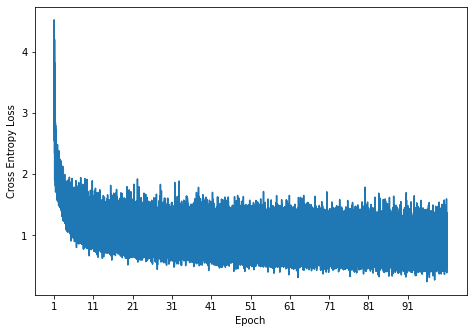

0.6556


In [ ]:
mlp8 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    TanHLayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    TanHLayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt8 = GradientDescentOptimizer(mlp8, 1e-2)
mlp8.train(opt8, train_I, train_labels,100, 32)
yh8 = mlp8.predict(test_I)
acc = sum(yh8 == np.array(test_labels))
accuracy = acc/yh8.shape[0]
print(accuracy)

Building and Training a 2 Layers MLP

(Using Leaky-ReLU)

100%|██████████| 20/20 [19:10<00:00, 57.50s/it]


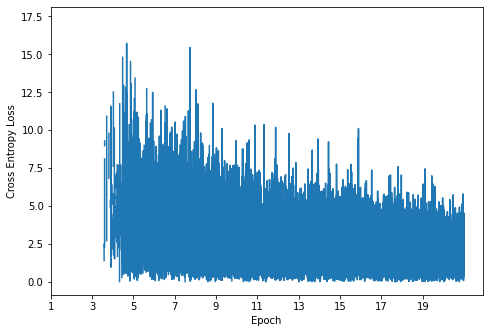

0.8016


In [ ]:
mlp4 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLU(1/2),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLU(1/2),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt4 = GradientDescentOptimizer(mlp4, 1e-2)
mlp4.train(opt4, train_I, train_labels, GRADIENT_STEPS,32)
yh4 = mlp4.predict(test_I)
acc = sum(yh4 == np.array(test_labels))
accuracy = acc/yh4.shape[0]
print(accuracy)

Same as above but with 100 epochs (using LeakyReLU):

100%|██████████| 100/100 [1:32:14<00:00, 55.35s/it]


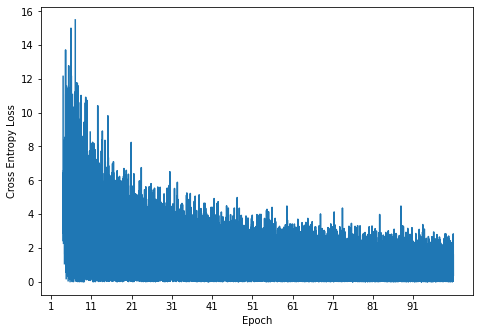

0.8168


In [ ]:
mlp9 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    LeakyReLU(1/2),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    LeakyReLU(1/2),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt9 = GradientDescentOptimizer(mlp9, 1e-2)
mlp9.train(opt9, train_I, train_labels,100, 32)
yh9 = mlp9.predict(test_I)
acc = sum(yh9 == np.array(test_labels))
accuracy = acc/yh9.shape[0]
print(accuracy)

L2 Regularization on a 2 layer ReLU Neural Network

100%|██████████| 20/20 [18:54<00:00, 56.72s/it]


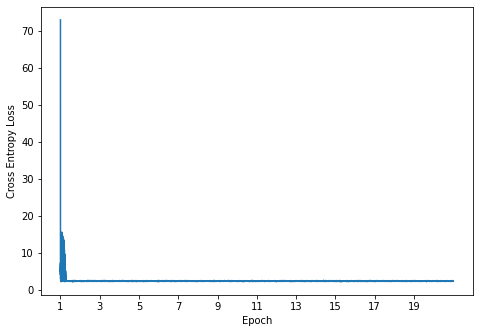

0.1


In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 20
n_features = 784

mlp5 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt5 = GradientDescent_L2Regularized(mlp5, 1e-2, lambda_L2=1/2)

mlp5.train(opt5, train_I, train_labels, GRADIENT_STEPS, 32)
yh = mlp5.predict(test_I)
acc = sum(yh == np.array(test_labels))
accuracy = acc/yh.shape[0]
print(accuracy)

For Task 3, question 6:
The model used was the following, but parameters of the model were modified to fit the architectural parameters showed in Table 1 in the report for testing.

The best models were the 1-layer MLP and 2-layer MLP

In [ ]:
HIDDEN_SIZE = 128
GRADIENT_STEPS = 100
n_features=train_I.shape[1]

mlp1 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt1 = GradientDescentOptimizer(mlp1, 1e-2)

mlp1.train(opt1, train_I, train_labels, GRADIENT_STEPS,32)
yh=mlp1.predict(test_I)
acc=sum(yh==np.array(test_labels))
accuracy=acc/yh.shape[0]
print(accuracy)

In [ ]:
HIDDEN_SIZE=128
mlp2 = MLP(
    LinearLayer(n_features, 128),
    ReLULayer(),
    LinearLayer(128, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt2 = GradientDescentOptimizer(mlp2, 1e-2)

mlp2.train(opt2, train_I, train_labels, 100,32)
yh=mlp2.predict(test_I)
print(test_labels)
print(yh)
acc=sum(yh==np.array(test_labels))
accuracy=acc/yh.shape[0]
print(accuracy)

FURTHER RESEARCH: vary the number of hidden units:

With only 5 hidden units:

(this is significantly faster and still has a high accuracy so there is a trade-off)

100%|██████████| 50/50 [01:23<00:00,  1.67s/it]


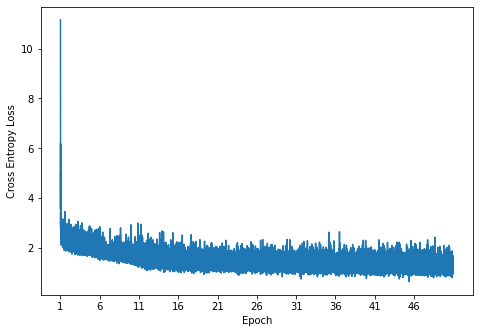

0.4807


In [ ]:
HIDDEN_SIZE = 5
GRADIENT_STEPS = 50
n_features = 784
batchSize = 32

mlp6 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt6 = GradientDescentOptimizer(mlp6, 1e-2)

mlp6.train(opt6, train_I, train_labels, GRADIENT_STEPS, batchSize)
yh = mlp6.predict(test_I)
acc = sum(yh == np.array(test_labels))
accuracy = acc/yh.shape[0]
print(accuracy)

Same model as above (with 5 hidden units) but with 2 layers:

100%|██████████| 50/50 [01:30<00:00,  1.81s/it]


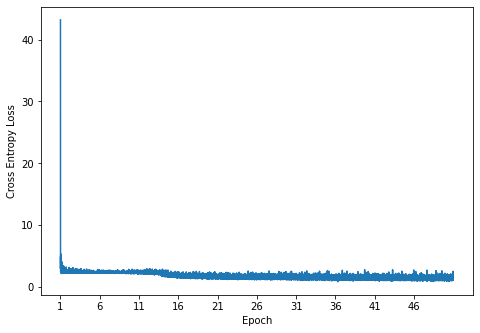

0.4094


In [ ]:
HIDDEN_SIZE = 5
GRADIENT_STEPS = 50
n_features = 784
batchSize = 32

mlp6 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt6 = GradientDescentOptimizer(mlp6, 1e-2)

mlp6.train(opt6, train_I, train_labels, GRADIENT_STEPS, batchSize)
yh = mlp6.predict(test_I)
acc = sum(yh == np.array(test_labels))
accuracy = acc/yh.shape[0]
print(accuracy)

With 50 hidden units:

(this seems like a good trade-off, we are at 2 percents away from the accuracy of the 50 hidden units layer but it takes much less time)

100%|██████████| 50/50 [07:48<00:00,  9.38s/it]


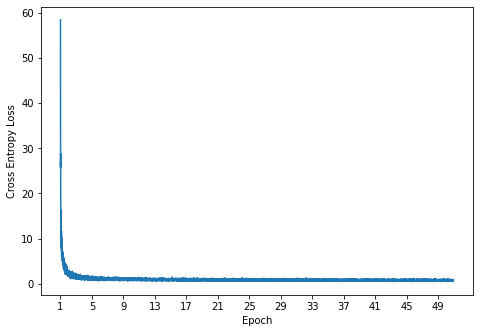

0.7135


In [ ]:
HIDDEN_SIZE = 25
GRADIENT_STEPS = 50
n_features = 784
batchSize = 128

mlp7 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)

opt7 = GradientDescentOptimizer(mlp7, 1e-2)

mlp7.train(opt7, train_I, train_labels, GRADIENT_STEPS,batchSize)
yh = mlp7.predict(test_I)
acc = sum(yh == np.array(test_labels))
accuracy = acc/yh.shape[0]
print(accuracy)

Comparing the testing accuracies for MLP models by varying the dataset size for training.

In [ ]:
#to obtain different quantities of images
print(train_labels.shape)
N,D=train_I.shape
permut=np.random.permutation(N)

trainI_6=train_I[permut[:6],:]
print(trainI_6.shape)
trainI_60=train_I[permut[:60],:]
trainI_600=train_I[permut[:600],:]
trainI_6000=train_I[permut[:6000],:]
trainI_60000=train_I

train_l6=train_labels[permut[:6]]
train_l60=train_labels[permut[:60]]
train_l600=train_labels[permut[:600]]
train_l6000=train_labels[permut[:6000]]
train_l60000=train_labels


(60000,)
(6, 784)


100%|██████████| 20/20 [00:00<00:00, 16858.14it/s]


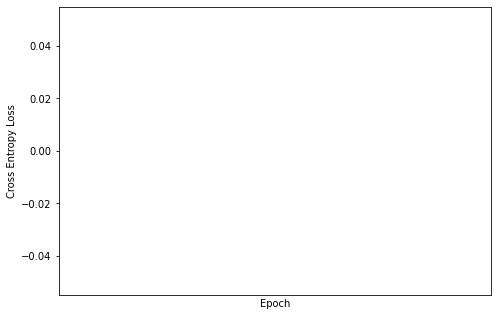

In [ ]:
HIDDEN_SIZE=128
mlp6 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt6 = GradientDescentOptimizer(mlp6, 1e-2)

mlp6.train(opt6, trainI_6, train_l6, 20,32)

100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


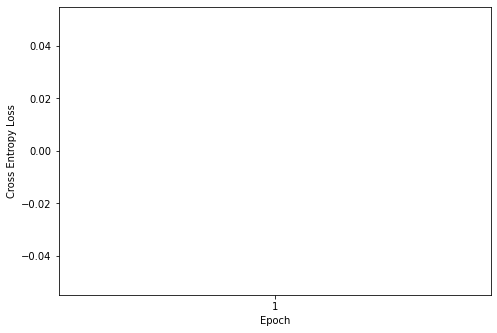

In [ ]:
HIDDEN_SIZE=128
mlp60 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt60 = GradientDescentOptimizer(mlp60, 1e-2)

mlp60.train(opt60, trainI_60, train_l60, 20,32)

100%|██████████| 20/20 [00:10<00:00,  1.82it/s]


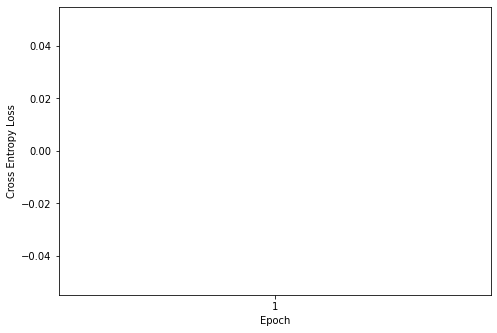

In [ ]:
HIDDEN_SIZE=128
mlp600 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt600 = GradientDescentOptimizer(mlp600, 1e-2)

mlp600.train(opt600, trainI_600, train_l600, 20,32)

100%|██████████| 20/20 [02:01<00:00,  6.10s/it]


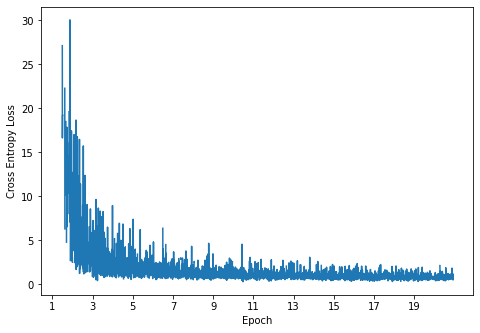

In [ ]:
HIDDEN_SIZE=128
mlp6000 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt6000 = GradientDescentOptimizer(mlp6000, 1e-2)

mlp6000.train(opt6000, trainI_6000, train_l6000, 20,32)

100%|██████████| 20/20 [17:11<00:00, 51.56s/it]


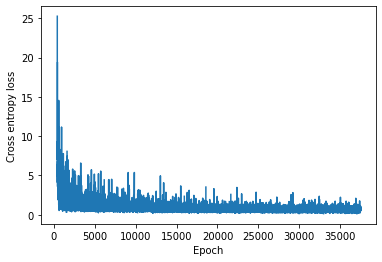

In [ ]:
HIDDEN_SIZE=128
mlp60000 = MLP(
    LinearLayer(n_features, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, HIDDEN_SIZE),
    ReLULayer(),
    LinearLayer(HIDDEN_SIZE, 10),
    SoftmaxOutputLayer()
)
opt60000 = GradientDescentOptimizer(mlp60000, 1e-2)

mlp60000.train(opt60000, trainI_60000, train_l60000, 20,32)

In [ ]:
yh6s=[]
yh6s.append(mlp6.predict(test_I))
yh6s.append(mlp60.predict(test_I))
yh6s.append(mlp600.predict(test_I))
yh6s.append(mlp6000.predict(test_I))
yh6s.append(mlp60000.predict(test_I))

test_accs=[]
for yhs in yh6s:
  acc=sum(yhs==np.array(test_labels))
  accuracy=acc/yhs.shape[0]
  test_accs.append(accuracy*100)






print(test_accs)

In [ ]:
plt.figure(figsize=(10,5))
c=['lightsteelblue','plum']
labels_test=['6 Articles','60 Articles','600 Articles','6000 Articles','60000 Articles']

lab=np.arange(len(labels_test))
plt.bar(lab,test_accs,align='center',color=c[0])
#plt.bar(lab,test_count_l,align='center',color=c[1],bottom=train_count_l)
#plt.legend(['Training Set: '+str(train_labels.shape[0])+' images', 'Testing Set: '+str(test_labels.shape[0])+' images'])
plt.xticks(lab,labels_test)
plt.ylim((0, 100))
#plt.legend(['Positive Reviews: '+str(valuepos),'Negative Reviews: '+str(valueneg)])
plt.xlabel('Training Size')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracies for Varying Training Sizes with MLP')
plt.show()

Comparing the testing accuracies for ConVNet models by varying the dataset size for training.

In [ ]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

In [ ]:
model=keras.models.Sequential([
    keras.layers.Conv2D(64,(3,3), activation='relu', input_shape=(28,28,1)),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Conv2D(64,(3,3), activation='relu'),
    keras.layers.MaxPooling2D(2,2),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(128, activation=tf.nn.relu),
    keras.layers.Dense(10, activation=tf.nn.softmax)
])

In [ ]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 13, 13, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 11, 11, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 flatten_3 (Flatten)         (None, 1600)              0         
                                                                 
 dense_9 (Dense)             (None, 128)              

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.save_weights('model.h5')

In [ ]:
history6=model.fit(trainI_6,train_l6, epochs=5)
test_loss6=model.evaluate(test_images1,test_labels)
model.load_weights('model.h5')

Epoch 1/5
1/1 [==============================] - 1s 515ms/step - loss: 2.3232 - accuracy: 0.0000e+00
Epoch 2/5
1/1 [==============================] - 0s 25ms/step - loss: 2.2325 - accuracy: 0.5000
Epoch 3/5
1/1 [==============================] - 0s 19ms/step - loss: 2.1544 - accuracy: 0.6667
Epoch 4/5
1/1 [==============================] - 0s 24ms/step - loss: 2.0519 - accuracy: 0.6667
Epoch 5/5
313/313 [==============================] - 4s 13ms/step - loss: 2.3366 - accuracy: 0.1813


In [ ]:
history60=model.fit(trainI_60,train_l60, epochs=5)
test_loss60=model.evaluate(test_images1,test_labels)
model.load_weights('model.h5')

Epoch 1/5
2/2 [==============================] - 0s 45ms/step - loss: 2.2909 - accuracy: 0.1167
Epoch 2/5
2/2 [==============================] - 0s 43ms/step - loss: 2.2151 - accuracy: 0.2000
Epoch 3/5
2/2 [==============================] - 0s 47ms/step - loss: 2.1252 - accuracy: 0.2000
Epoch 4/5
2/2 [==============================] - 0s 40ms/step - loss: 2.0134 - accuracy: 0.3500
Epoch 5/5
313/313 [==============================] - 4s 13ms/step - loss: 1.8872 - accuracy: 0.2430


In [ ]:
history600=model.fit(trainI_600,train_l600, epochs=5)
test_loss600=model.evaluate(test_images1,test_labels)
model.load_weights('model.h5')

Epoch 1/5
19/19 [==============================] - 1s 46ms/step - loss: 1.8448 - accuracy: 0.3617
Epoch 2/5
19/19 [==============================] - 1s 47ms/step - loss: 1.1379 - accuracy: 0.5917
Epoch 3/5
19/19 [==============================] - 1s 46ms/step - loss: 0.9412 - accuracy: 0.6583
Epoch 4/5
19/19 [==============================] - 1s 46ms/step - loss: 0.8444 - accuracy: 0.7100
Epoch 5/5
313/313 [==============================] - 4s 13ms/step - loss: 0.6996 - accuracy: 0.7354


In [ ]:
history6000=model.fit(trainI_6000,train_l6000, epochs=5)
test_loss6000=model.evaluate(test_images1,test_labels)
model.load_weights('model.h5')

Epoch 1/5
188/188 [==============================] - 9s 46ms/step - loss: 0.9883 - accuracy: 0.6278
Epoch 2/5
188/188 [==============================] - 9s 46ms/step - loss: 0.5302 - accuracy: 0.8007
Epoch 3/5
188/188 [==============================] - 9s 46ms/step - loss: 0.4371 - accuracy: 0.8402
Epoch 4/5
188/188 [==============================] - 9s 47ms/step - loss: 0.3652 - accuracy: 0.8687
Epoch 5/5
313/313 [==============================] - 4s 13ms/step - loss: 0.4287 - accuracy: 0.8471


In [ ]:
history60000=model.fit(trainI_60000,train_l60000, epochs=5)
test_loss60000=model.evaluate(test_images1,test_labels)
model.load_weights('model.h5')

Epoch 1/5
1875/1875 [==============================] - 91s 48ms/step - loss: 0.4872 - accuracy: 0.8194
Epoch 2/5
1875/1875 [==============================] - 89s 47ms/step - loss: 0.2983 - accuracy: 0.8897
Epoch 3/5
1875/1875 [==============================] - 87s 46ms/step - loss: 0.2517 - accuracy: 0.9072
Epoch 4/5
1875/1875 [==============================] - 89s 47ms/step - loss: 0.2214 - accuracy: 0.9172
Epoch 5/5
313/313 [==============================] - 4s 12ms/step - loss: 0.2552 - accuracy: 0.9075


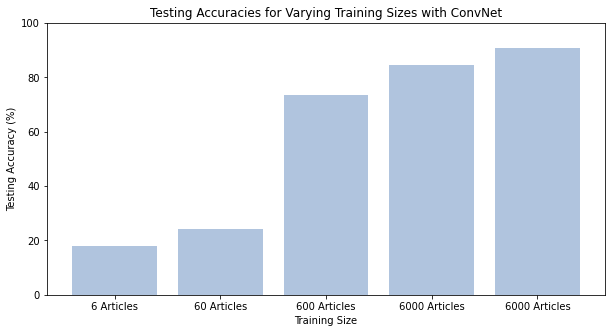

In [ ]:
test_accuracies_conv=[test_loss6[1]*100,test_loss60[1]*100,test_loss600[1]*100,test_loss6000[1]*100,test_loss60000[1]*100]

plt.figure(figsize=(10,5))
c=['lightsteelblue','plum']
labels_test=['6 Articles','60 Articles','600 Articles','6000 Articles','60000 Articles']

lab=np.arange(len(labels_test))
plt.bar(lab,test_accuracies_conv,align='center',color=c[0])
#plt.bar(lab,test_count_l,align='center',color=c[1],bottom=train_count_l)
#plt.legend(['Training Set: '+str(train_labels.shape[0])+' images', 'Testing Set: '+str(test_labels.shape[0])+' images'])
plt.xticks(lab,labels_test)
plt.ylim((0, 100))
#plt.legend(['Positive Reviews: '+str(valuepos),'Negative Reviews: '+str(valueneg)])
plt.xlabel('Training Size')
plt.ylabel('Testing Accuracy (%)')
plt.title('Testing Accuracies for Varying Training Sizes with ConvNet')
plt.show()